In [1]:
import tensorflow as tf
import matplotlib as mpl
from trainingUtils import save, load
from layers import AdaIN
import scipy.io as sio
import numpy as np
import os
from preprocessing import DataStream
import matplotlib.pyplot as plt
from multi_slice_viewer import multi_slice_viewer
from init_weights import encoder_weights, decoder_weights
from tqdm import tqdm
from Model import Model

%matplotlib inline
mpl.rcParams['figure.dpi']= 200

In [2]:
ds  = DataStream(5)
dct = ds.read()
sess = tf.Session()
sess.as_default()
mod = Model(sess,7)#ckpt = '../CKPTS/ckpts3/model.ckpt') ne dela, ker star...
sess.run(tf.global_variables_initializer())

100%|██████████| 2487/2487 [00:03<00:00, 634.61it/s]


In [3]:
brain_mask = ds.get_mask(mode = 'brain', ID='01839bc52707c687c3b8c643ad4aaef0445360014303163c1c31af23')[:,:,0]
t1w =ds.get_mask(mode = 't1w', ID='01839bc52707c687c3b8c643ad4aaef0445360014303163c1c31af23')[:,:,0]
seg = ds.get_mask(mode = 'seg', ID='01839bc52707c687c3b8c643ad4aaef0445360014303163c1c31af23')[:,:,0]
seg_s = ds.get_mask(mode = 'seg', ID="3d80f47f971140cdf6c35e8852cc3cc276767d1ddcfd1918fd4e8beb")[:,:,0]

print(np.array(t1w).shape)


(192, 224)


In [4]:
idc, c = mod.data.get_fixed_batch('01839bc52707c687c3b8c643ad4aaef0445360014303163c1c31af23')
ids, s = mod.data.get_fixed_batch()

output = sess.run(mod.output, feed_dict={mod.input_c : c, mod.input_s : s})

(7, 192, 224, 1)
(7, 192, 224, 1)


In [5]:
output = output[0,:,:,0]
c= c[0,:,:,0]
s = s[0,:,:,0]
output_r = np.ravel(output)
c_r = np.ravel(c)
s_r = np.ravel(s)

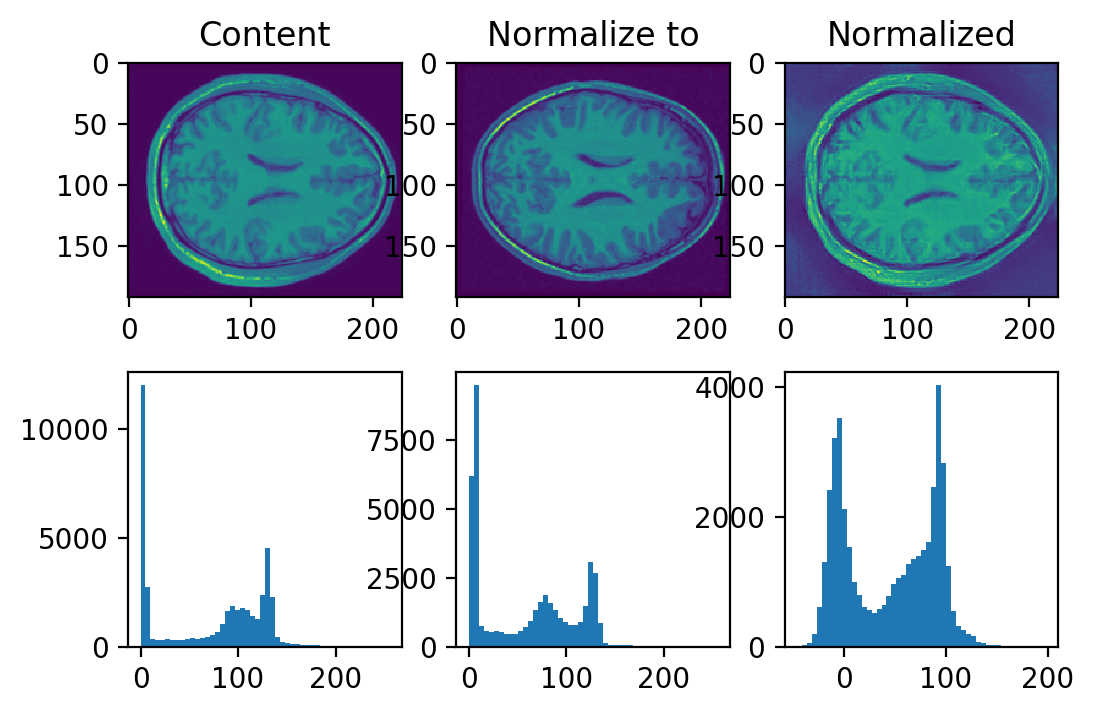

In [6]:
mpl.rcParams['figure.dpi']= 200
f, ((ax1, ax2,ax3), (ax4, ax5,ax6)) = plt.subplots(2, 3)
_=ax1.set_title('Content')
_=ax1.imshow(c)
_=ax2.set_title('Normalize to')
_=ax2.imshow(s)
_=ax3.set_title('Normalized')
_=ax3.imshow(output)
#ax4.hist(np.ma.masked_where(c_r<10, c_r),bins=50)
_=ax4.hist(c_r,bins=50)
_=ax5.hist(s_r,bins=50)
_=ax6.hist(output_r,bins=50)

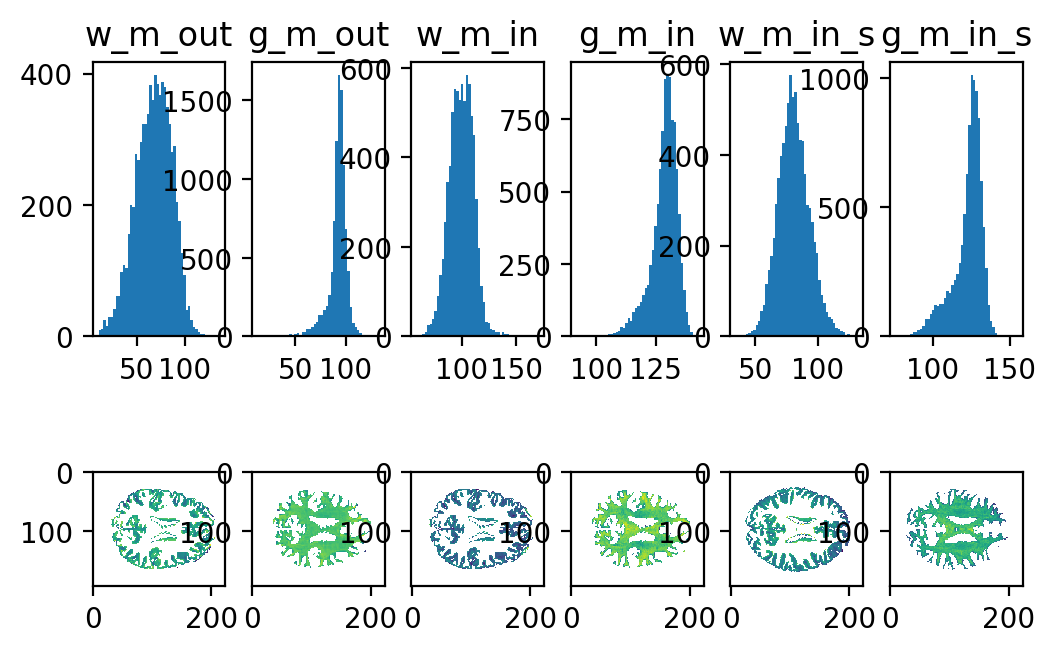

In [7]:
w_m = np.ma.masked_where(seg!=2.0,seg)
w_m/=2.0
g_m = np.ma.masked_where(seg!=3.0,seg)
g_m/=3.0
w_m_s = np.ma.masked_where(seg_s!=2.0,seg_s)
w_m_s/=2.0
g_m_s = np.ma.masked_where(seg_s!=3.0,seg_s)
g_m_s/=3.0
#plt.hist(np.ravel(brain_mask))
#print(w_m*output)
f, ax = plt.subplots(2,6)
a = w_m*output
_=ax[0,0].hist(np.ravel(np.ma.masked_where(a<10,a)),bins = 50)
_=ax[0,0].set_title('w_m_out')
a = g_m*output
_=ax[0,1].hist(np.ravel(np.ma.masked_where(a<10,a)),bins = 50)
_=ax[0,1].set_title('g_m_out')
_=ax[0,2].hist(np.ravel(w_m*c),bins = 50)
_=ax[0,2].set_title('w_m_in')
_=ax[0,3].hist(np.ravel(g_m*c),bins = 50)
_=ax[0,3].set_title('g_m_in')
_=ax[0,4].hist(np.ravel(w_m_s*s),bins = 50)
_=ax[0,4].set_title('w_m_in_s')
_=ax[0,5].hist(np.ravel(g_m_s*s),bins = 50)
_=ax[0,5].set_title('g_m_in_s')
_=ax[1,0].imshow(w_m*output)
_=ax[1,1].imshow(g_m*output)
_=ax[1,2].imshow(w_m*c)
_=ax[1,3].imshow(g_m*c)
_=ax[1,4].imshow(w_m_s*s)
_=ax[1,5].imshow(g_m_s*s)
#plt.hist(np.ravel(a*t1w),bins = 50)

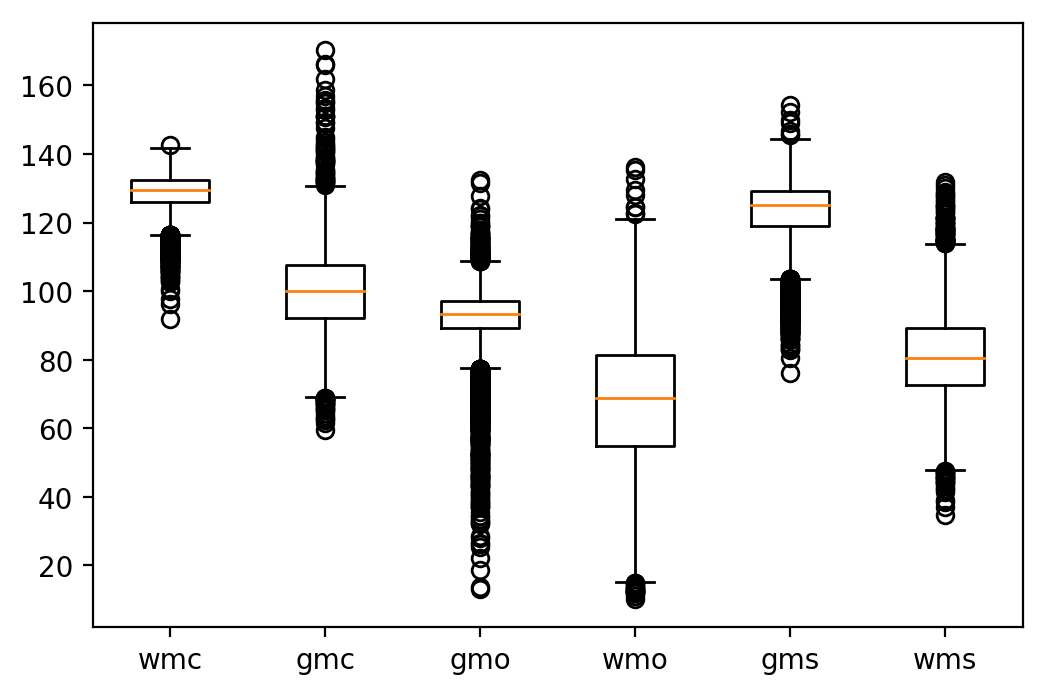

In [8]:
a= np.ravel(g_m*c)
wmc=a[a>10]
b= np.ravel(w_m*c)
gmc=b[b>10]

a = np.ravel(g_m*output)
gmo = a[a>10]
a = np.ravel(w_m*output)
wmo = a[a>10]

a = np.ravel(g_m_s*s)
gms = a[a>10]
a = np.ravel(w_m_s*s)
wms = a[a>10]
#plt.set_title("wmc,gmc,gmo,wmo,gms,wms")
_= plt.boxplot(x=(wmc,gmc,gmo,wmo,gms,wms),labels=("wmc","gmc","gmo","wmo","gms","wms"))

In [9]:
def Z(a,b):
    return np.abs(np.mean(a)-np.mean(b))/np.sqrt(np.square(np.std(a))+np.square(np.std(b)))
print("\noutput contrast: %s"%(Z(wmo,gmo)))
print("\ninput content contrast: %s"%(Z(wmc,gmc)))
print("\ninput style contrast: %s"%(Z(wms,gms)))
print("""
    If the Z-statistic is less than 2, the two samples are the same.

    If the Z-statistic is between 2.0 and 2.5, the two samples are marginally different

    If the Z-statistic is between 2.5 and 3.0, the two samples are significantly different

    If the Z-statistic is more then 3.0, the two samples are highly signficantly different""")


output contrast: 1.1335891366563928

input content contrast: 2.2505138207470927

input style contrast: 2.599411739761609

    If the Z-statistic is less than 2, the two samples are the same.

    If the Z-statistic is between 2.0 and 2.5, the two samples are marginally different

    If the Z-statistic is between 2.5 and 3.0, the two samples are significantly different

    If the Z-statistic is more then 3.0, the two samples are highly signficantly different
